In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("mobiles_dataset.csv")

conversion_rates = {
    "Pakistan.PKR": 0.0036,
    "India.INR": 0.011,
    "China.CNY": 0.14,
    "Dubai.AED": 0.27,
    "USA.USD": 1 
}

for country_currency in conversion_rates:
    original_col = f"Launched.Price.{country_currency}"
    if original_col in df.columns:
        df[original_col] = (
            df[original_col]
            .astype(str)
            .str.replace(r'[^\d.]', '', regex=True)  
            .replace('', np.nan)  
        )
     
        df[original_col] = pd.to_numeric(df[original_col], errors='coerce')


for country_currency in conversion_rates:
    original_col = f"Launched.Price.{country_currency}"
    new_col = f"Price_{country_currency}_USD"
    if original_col in df.columns:
        df[new_col] = df[original_col] * conversion_rates[country_currency]


df["Price_USD"] = df["Launched.Price.USA.USD"]


df['Company.Name'] = df['Company.Name'].str.strip().str.lower()
df['RAM'] = (
    df['RAM']
    .astype(str)
    .str.replace(r'[^\d.]', '', regex=True)  # Raw string for regex
    .astype(float)
)

df['Battery.Capacity.mAh'] = (
    df['Battery.Capacity.mAh']
    .astype(str)
    .str.replace(r'[^\d.]', '', regex=True)  # Raw string for regex
    .astype(float)
)

df = df.dropna(subset=[
    'Battery.Capacity.mAh',
    'RAM',
    'Price_USD',
    'Price_Pakistan.PKR_USD',
    'Price_India.INR_USD',
    'Price_China.CNY_USD',
    'Price_Dubai.AED_USD',
    'Price_USA.USD_USD'
])




=== Battery Capacity vs Price ===
Global correlation: -0.04
Pakistan correlation: -0.06
India    correlation: -0.02
China    correlation: -0.04
Dubai    correlation: -0.05
USA      correlation: -0.04


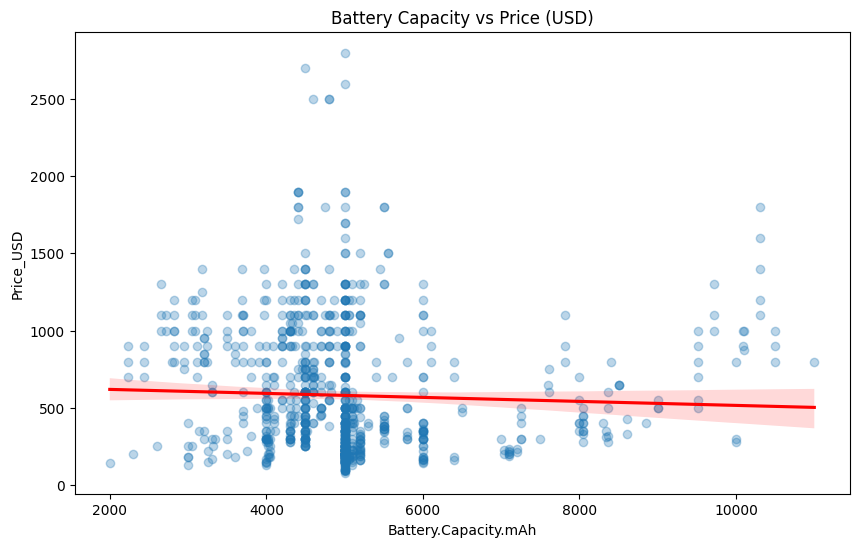

In [10]:
price_columns = [
    'Price_Pakistan.PKR_USD', 
    'Price_India.INR_USD', 
    'Price_China.CNY_USD',
    'Price_Dubai.AED_USD', 
    'Price_USA.USD_USD'
]

print("\n=== Battery Capacity vs Price ===")
battery_price_corr = df['Battery.Capacity.mAh'].corr(df['Price_USD'])
print(f"Global correlation: {battery_price_corr:.2f}")

for col in price_columns:
    corr = df['Battery.Capacity.mAh'].corr(df[col])
    print(f"{col.split('_')[1].split('.')[0]:<8} correlation: {corr:.2f}")

plt.figure(figsize=(10, 6))
sns.regplot(x='Battery.Capacity.mAh', y='Price_USD', data=df, 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Battery Capacity vs Price (USD)')
plt.show()

**The analysis reveals a very weak negative correlation (r ≈ -0.04 to -0.06) between battery capacity and smartphone prices across all regions, indicating no meaningful relationship. This suggests that larger batteries do not drive higher prices in the dataset, likely because budget phones often prioritize battery size to compensate for lower-end specs, while premium phones focus on features like cameras, processors, or brand value.**


=== RAM vs Price ===
Global correlation: 0.11
Pakistan correlation: 0.07
India    correlation: 0.10
China    correlation: 0.12
Dubai    correlation: 0.11
USA      correlation: 0.11


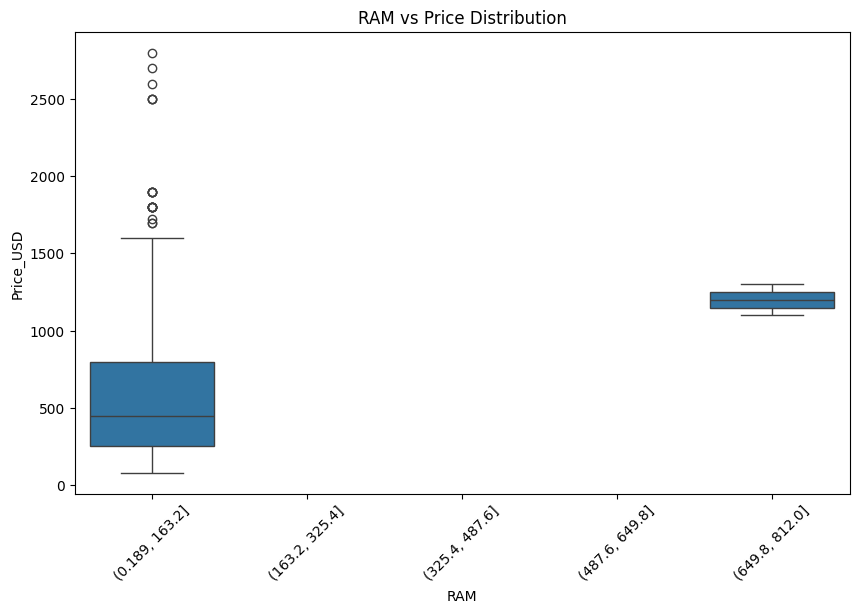

In [11]:
print("\n=== RAM vs Price ===")
ram_price_corr = df['RAM'].corr(df['Price_USD'])
print(f"Global correlation: {ram_price_corr:.2f}")
for col in price_columns:
    corr = df['RAM'].corr(df[col])
    print(f"{col.split('_')[1].split('.')[0]:<8} correlation: {corr:.2f}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=pd.cut(df['RAM'], bins=5), y='Price_USD', data=df)
plt.title('RAM vs Price Distribution')
plt.xticks(rotation=45)
plt.show()



**The weak positive correlations (r ≈ 0.07–0.12) suggest a slight tendency for higher RAM sizes to correlate with higher smartphone prices, but the relationship is not strong and varies minimally across regions. This indicates that while RAM may play a role in pricing, it is not a dominant factor.**



In [13]:
print("\n=== Apple Price Variation ===")
apple_df = df[df['Company.Name'] == 'apple']

apple_variation = apple_df[price_columns].std().mean()
other_variation = df[df['Company.Name'] != 'apple'].groupby('Company.Name')[price_columns].std().mean(axis=1).mean()

print(f"Apple's average price variation: ${apple_variation:.2f}")
print(f"Other brands' average variation: ${other_variation:.2f}")


apple_avg = apple_df[price_columns].mean()
print(f"\nHighest Apple markup in: {apple_avg.idxmax()} (${apple_avg.max():.2f})")
stable_brands = df.groupby('Company.Name')[price_columns].std().mean(axis=1).nsmallest(3)
print("\nMost stable brands:")
print(stable_brands)


=== Apple Price Variation ===
Apple's average price variation: $266.82
Other brands' average variation: $262.94

Highest Apple markup in: Price_India.INR_USD ($1132.98)

Most stable brands:
Company.Name
nokia      45.206178
iqoo       58.308283
infinix    94.766459
dtype: float64


**Apple devices show slightly higher price variations across regions compared to other brands, indicating they adjust prices more by market but remain aligned with industry norms. Their highest prices occur in India, likely due to taxes and luxury branding,while brands like Nokia and iQoo maintain stable global pricing by focusing on budget segments or local manufacturing to avoid tariffs. This highlights Apple’s premium market strategy versus budget brands’ consistency.**

In [14]:
print("\n=== Brand Segmentation ===")

def price_category(price):
    if price < 300: return 'Budget'
    elif 300 <= price <= 700: return 'Mid-Range'
    else: return 'Premium'

df['Price_Category'] = df['Price_USD'].apply(price_category)

segmentation = df.groupby(['Company.Name', 'Price_Category']).size().unstack().fillna(0)
print("\nBrand segmentation matrix:")
print(segmentation)

# Brands covering all segments
full_coverage = segmentation[(segmentation['Budget'] > 0) & 
                            (segmentation['Mid-Range'] > 0) &
                            (segmentation['Premium'] > 0)]
print("\nBrands covering all segments:")
print(full_coverage.index.tolist())



=== Brand Segmentation ===

Brand segmentation matrix:
Price_Category  Budget  Mid-Range  Premium
Company.Name                              
apple              0.0        8.0     89.0
google             0.0       12.0      9.0
honor             29.0       37.0     25.0
huawei             0.0       15.0     27.0
infinix           41.0       15.0      0.0
iqoo               0.0        3.0      0.0
lenovo            10.0        5.0      0.0
motorola          22.0       33.0      7.0
nokia             10.0        0.0      0.0
oneplus           10.0       23.0     20.0
oppo              46.0       59.0     24.0
poco              17.0       15.0      0.0
realme            43.0       26.0      0.0
samsung           26.0       19.0     39.0
sony               0.0        3.0      6.0
tecno             18.0       12.0      9.0
vivo              33.0       37.0     16.0
xiaomi             6.0       12.0      9.0

Brands covering all segments:
['honor', 'motorola', 'oneplus', 'oppo', 'samsung', '

**The segmentation reveals distinct brand strategies: Apple and Google focus on premium/mid-range phones (no budget options), while Infinix, Realme, and Poco specialize in budget devices. Brands like Samsung, Xiaomi, Vivo, and Oppo cover all segments (e.g., Samsung: 26 budget, 19 mid-range, 39 premium models), balancing affordability and premium features. Only 8 of 18 brands compete across all price tiers, reflecting varied approaches—some prioritize niche markets (e.g., Apple’s premium focus) while others diversify to attract a wider audience (e.g., Samsung’s full-range strategy). This highlights the trade-off between specialization and broad market appeal.**

In [15]:
print("\n=== Regional Pricing ===")

avg_prices = df[price_columns].mean()
print("\nAverage prices by region:")
print(avg_prices.sort_values())
most_affordable = avg_prices.idxmin()
print(f"\nMost affordable region: {most_affordable.split('_')[1].split('.')[0]}")

regional_diffs = {}
for brand in df['Company.Name'].unique():
    brand_prices = df[df['Company.Name'] == brand][price_columns]
    if not brand_prices.empty:
        min_price = brand_prices.min().min()
        max_price = brand_prices.max().max()
        diff_pct = ((max_price - min_price)/max_price)*100
        if diff_pct > 30:  
            regional_diffs[brand] = diff_pct

print("\nBrands with significant regional price differences (>30%):")
for brand, diff in regional_diffs.items():
    print(f"{brand.title()}: {diff:.1f}% difference")


=== Regional Pricing ===

Average prices by region:
Price_Pakistan.PKR_USD    449.934239
Price_China.CNY_USD       530.741362
Price_India.INR_USD       552.823682
Price_USD                 579.623784
Price_Dubai.AED_USD       586.029016
dtype: float64

Most affordable region: Pakistan

Brands with significant regional price differences (>30%):
Apple: 91.8% difference
Samsung: 96.0% difference
Oneplus: 90.7% difference
Vivo: 96.0% difference
Iqoo: 54.2% difference
Oppo: 95.9% difference
Realme: 83.6% difference
Xiaomi: 88.1% difference
Lenovo: 89.1% difference
Motorola: 94.0% difference
Huawei: 90.5% difference
Nokia: 67.5% difference
Sony: 74.3% difference
Google: 87.3% difference
Tecno: 95.9% difference
Infinix: 89.5% difference
Honor: 94.7% difference
Poco: 83.6% difference


**Pakistan offers the most affordable smartphone prices on average ($450), likely due to local manufacturing or budget-focused market strategies, while Dubai and the USA have the highest prices. Brands like Samsung, Apple, and Vivo show extreme regional price differences (>95%), driven by factors such as import taxes (e.g., India’s high tariffs on iPhones), luxury branding in wealthier markets, or localized production. Even budget brands like Tecno and Infinix exhibit large variations (~90%), suggesting aggressive pricing adjustments in developing markets to stay competitive. These disparities highlight how global brands adapt to regional economic conditions, regulatory costs, and consumer purchasing power.**

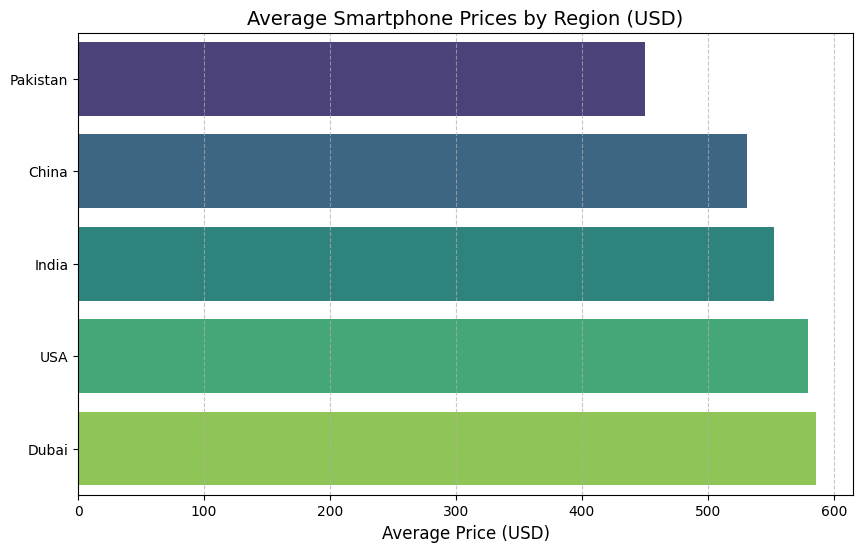

In [17]:
price_columns = [
    'Price_Pakistan.PKR_USD',
    'Price_India.INR_USD',
    'Price_China.CNY_USD',
    'Price_Dubai.AED_USD',
    'Price_USA.USD_USD'
]

avg_prices = df[price_columns].mean().reset_index()
avg_prices.columns = ['Region', 'Average_Price']
avg_prices['Region'] = avg_prices['Region'].str.split('_').str[1].str.split('.').str[0]


plt.figure(figsize=(10, 6))
sns.barplot(
    x='Average_Price',
    y='Region',
    hue='Region',  
    data=avg_prices.sort_values('Average_Price'),
    palette='viridis',
    dodge=False,  
    legend=False
)
plt.title('Average Smartphone Prices by Region (USD)', fontsize=14)
plt.xlabel('Average Price (USD)', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

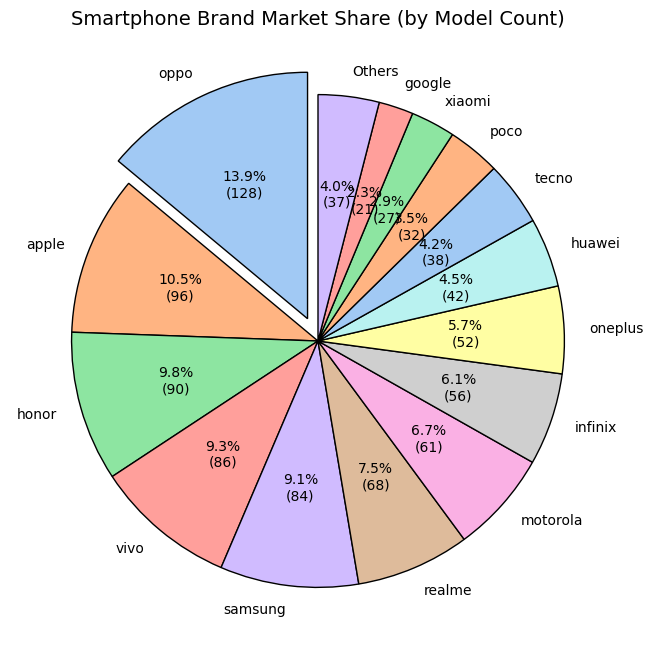

In [18]:
brand_counts = df['Company.Name'].value_counts()
total_models = brand_counts.sum()


threshold = total_models * 0.02  
mask = brand_counts > threshold
market_share = brand_counts[mask]
market_share['Others'] = brand_counts[~mask].sum()


plt.figure(figsize=(10, 8))
explode = [0.1 if i == market_share.idxmax() else 0 for i in market_share.index]

plt.pie(
    market_share,
    labels=market_share.index,
    autopct=lambda p: f'{p:.1f}%\n({int(p * total_models/100)})',
    startangle=90,
    explode=explode,
    colors=sns.color_palette("pastel"),
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Smartphone Brand Market Share (by Model Count)', fontsize=14)
plt.show()


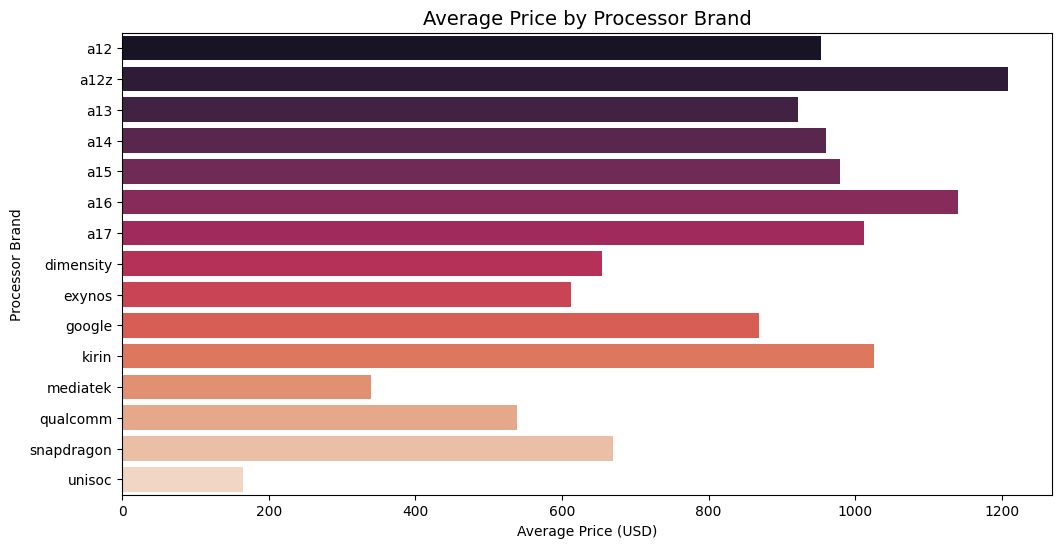

In [22]:
df['Processor_Brand'] = df['Processor'].str.split().str[0].str.lower()

processor_prices = df.groupby('Processor_Brand')['Price_USD'].agg(['mean', 'count'])
processor_prices = processor_prices[processor_prices['count'] > 10]

plt.figure(figsize=(12, 6))
sns.barplot(
    x='mean',
    y=processor_prices.index,
    hue=processor_prices.index,  
    data=processor_prices,
    palette="rocket",
    legend=False,
    dodge=False ) 
plt.title('Average Price by Processor Brand', fontsize=14)
plt.xlabel('Average Price (USD)')
plt.ylabel('Processor Brand')
plt.show()



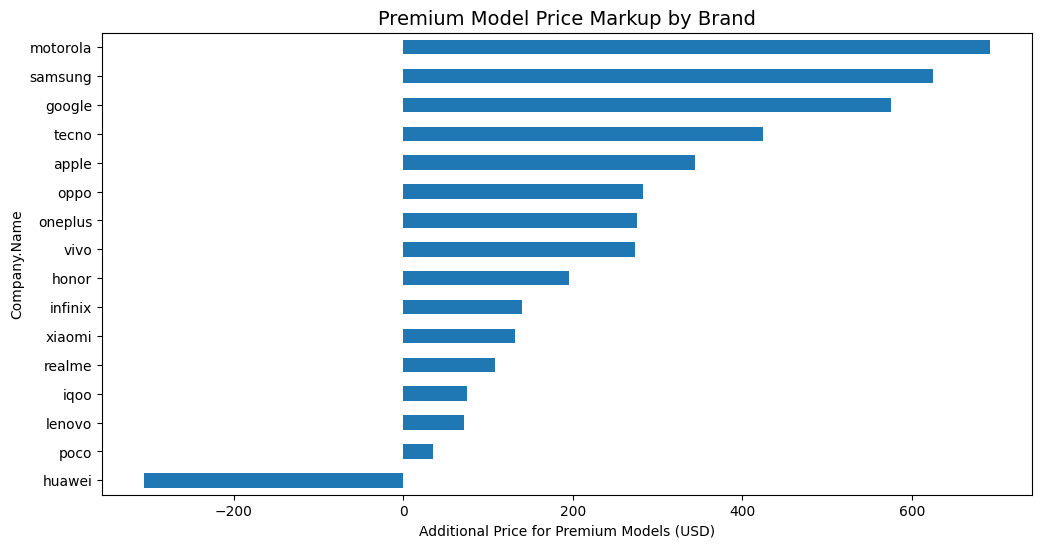

In [24]:
df['Premium_Model'] = df['Model.Name'].str.contains(
    'Pro|Max|Ultra|Fold|Flip', case=False).astype(int)

premium_pricing = df.groupby(['Company.Name', 'Premium_Model'])['Price_USD'].mean().unstack()
premium_pricing['Price_Premium'] = premium_pricing[1] - premium_pricing[0]

plt.figure(figsize=(12, 6))
premium_pricing['Price_Premium'].dropna().sort_values().plot(kind='barh')
plt.title('Premium Model Price Markup by Brand', fontsize=14)
plt.xlabel('Additional Price for Premium Models (USD)')
plt.show()


**Premium smartphone models command significant price markups for established brands like Apple (+$600) and Samsung, leveraging brand reputation and advanced features. However, budget brands like huawei show negative markups, likely due to aggressive discounting, highlighting the challenge of justifying higher prices without strong brand equity. While premium labels generally boost prices, success depends on consistent branding and market positioning.**